In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
os.getcwd()

'/Users/shrutikaushal/Documents/GitHub/Prediction-of-commercial-insurance-payments-for-surgical-procedure-using-DataRobot'

In [3]:
path = os.getcwd()

In [4]:
group_df = pd.read_excel(path+
    '/Data_Files/JnJ_Files/cost_discharge_physpec_ippct.xlsx')

In [5]:
group_df.head()

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct
0,ankle_fix,16741.5136,0.621714,ORTHOPEDIC SURGERY (ORS),0.542798
1,ant_cerv_fusion,18848.1697,0.846973,NEUROLOGICAL SURGERY (NS),0.575495
2,ant_tls_fusion,49478.1242,0.596666,ORTHOPEDIC SURGERY (ORS),0.983543
3,bariatric,14585.5550,0.945035,GENERAL SURGERY (GS),0.911311
4,breast reconstruction,13690.8043,0.929970,PLASTIC SURGERY (PS),0.246127


In [6]:
group_df.shape

(50, 5)

### Visualizing the numerical features

<IPython.core.display.Javascript object>


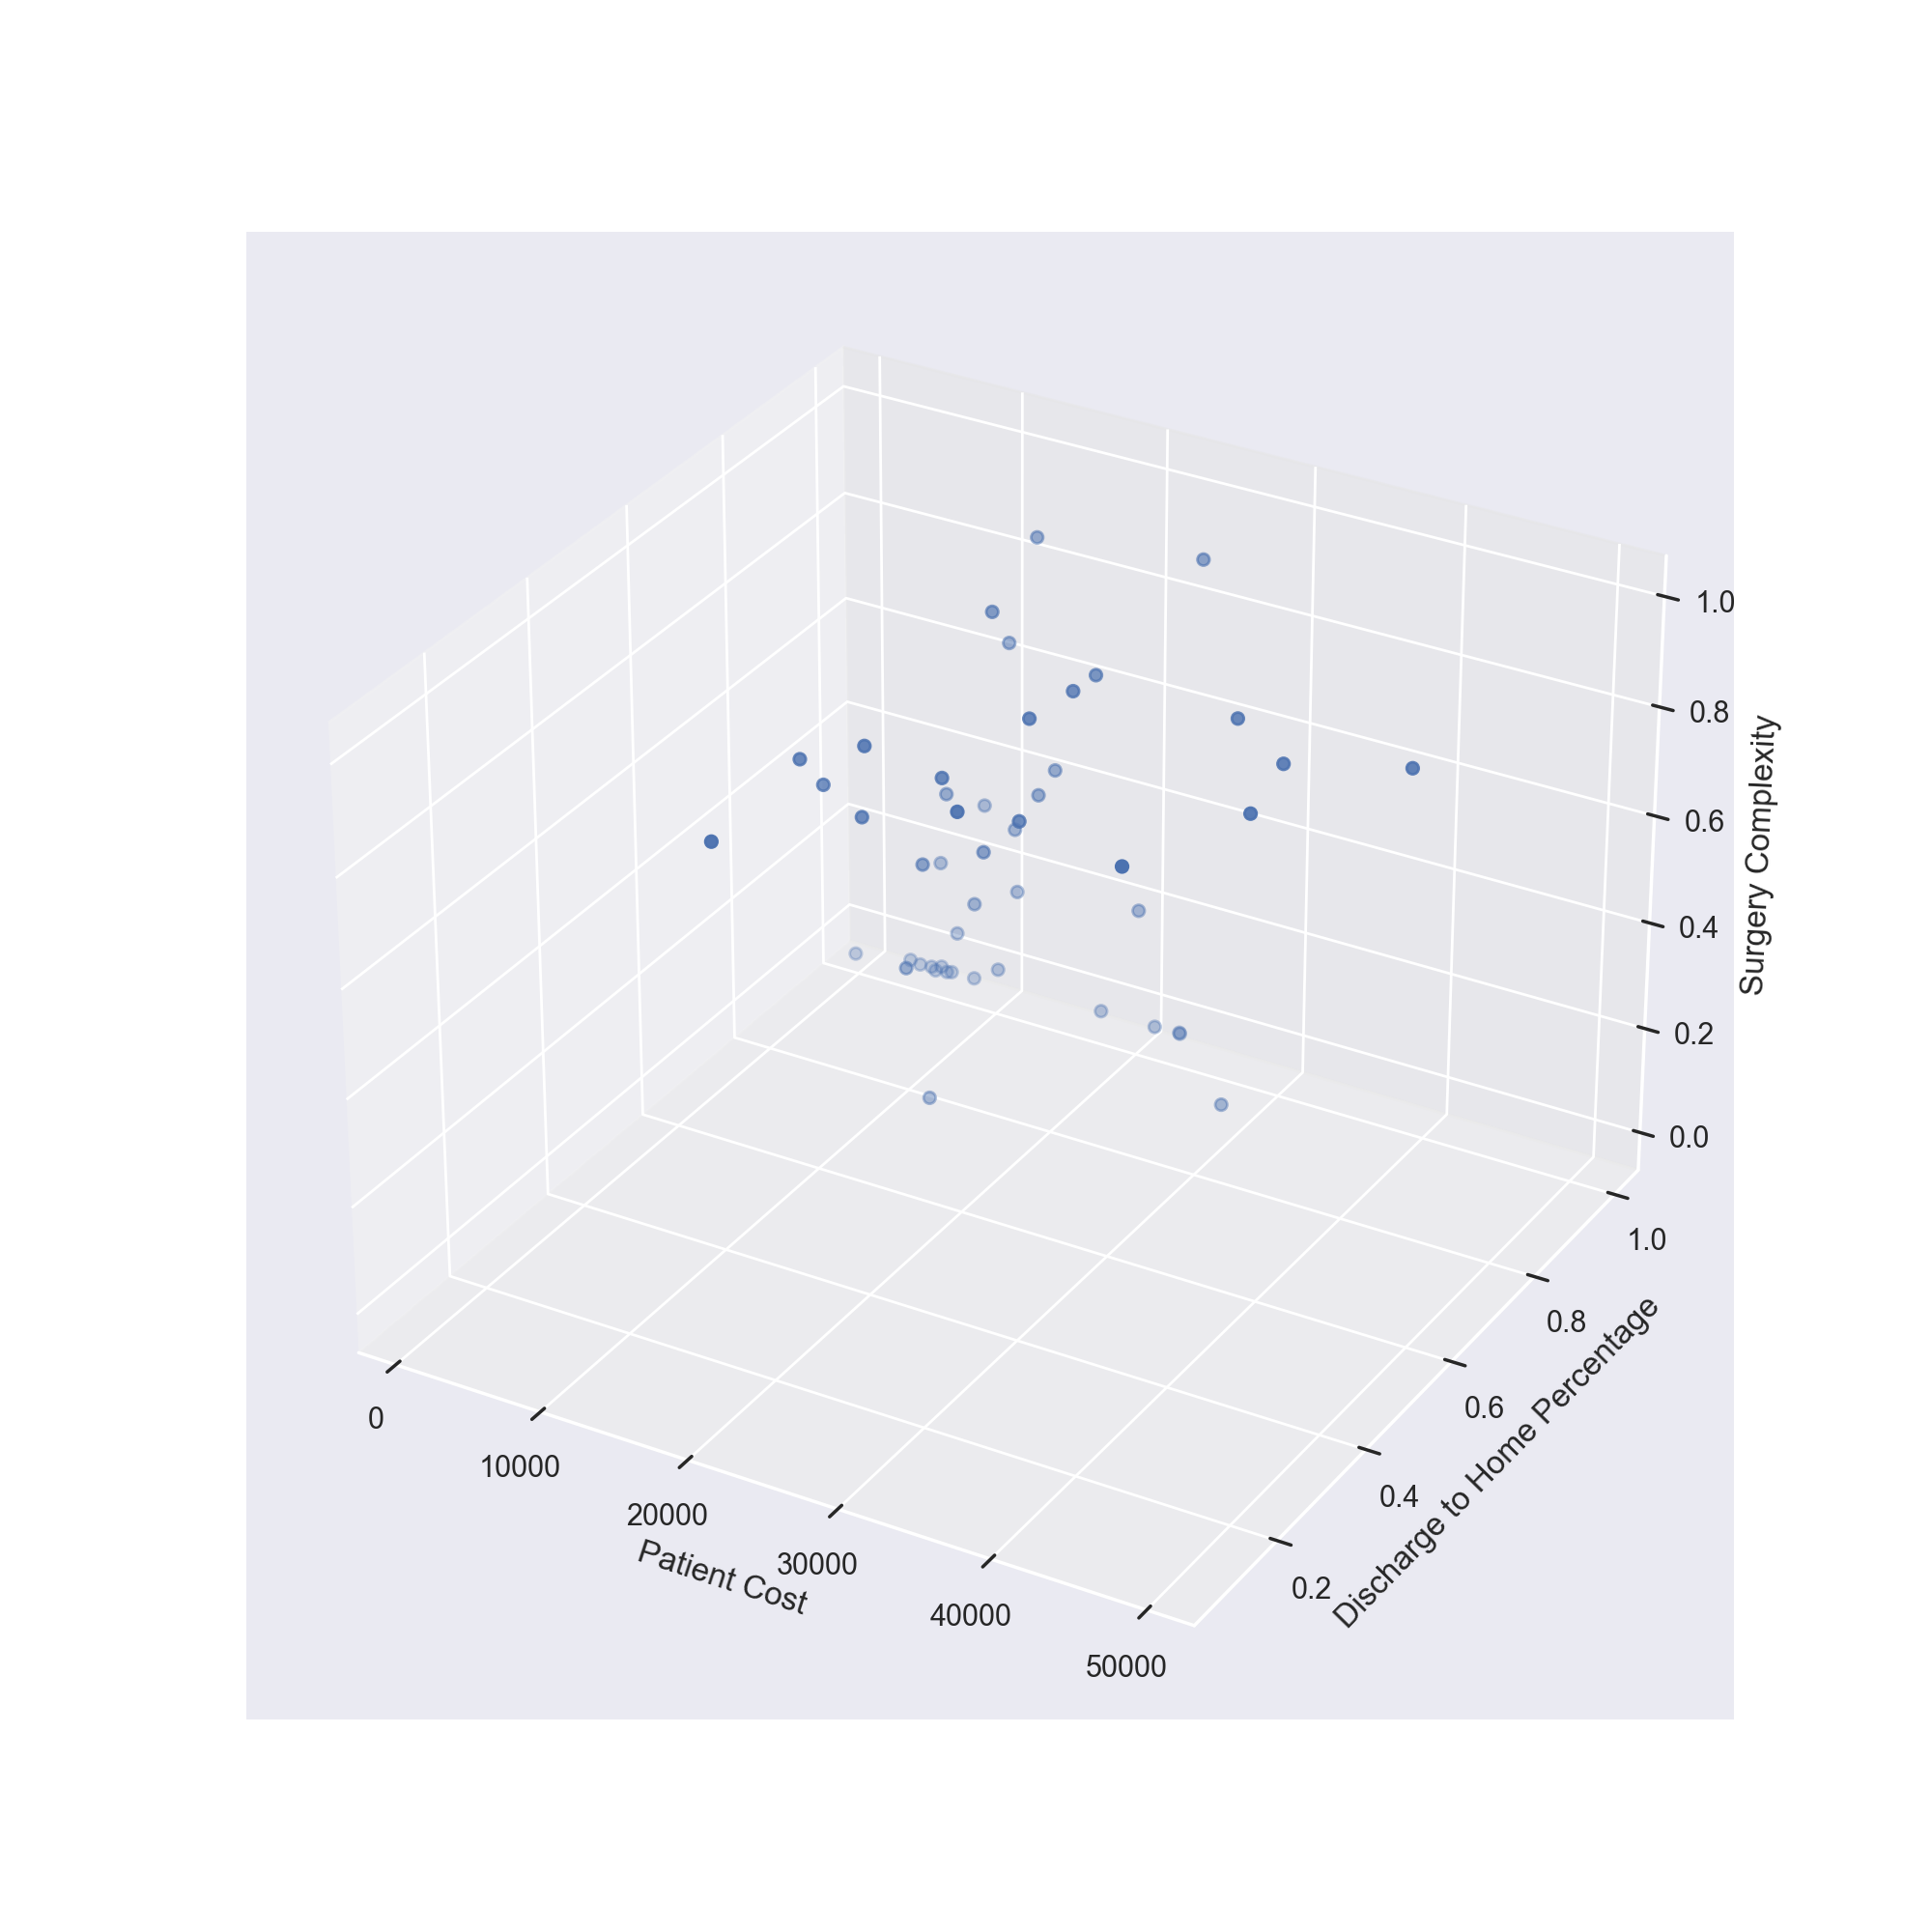

In [7]:
sns.set(style = "darkgrid")

%matplotlib notebook
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = '3d')

x = group_df['pat_cost']
y = group_df['discharge_to_home_pct']
z = group_df['IP_pct']

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z)

plt.show()


### Performing preliminary clustering

#### K-MEANS

In [8]:
X = group_df[['pat_cost','discharge_to_home_pct','IP_pct']].values

In [9]:
# determining the optimal number of clusters
clusters = np.arange(1,10)
inertia = []
for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X)
    inertia.append(model.inertia_)

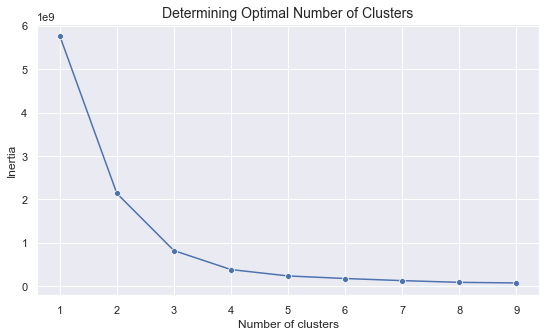

In [10]:
%matplotlib inline
plt.figure(figsize = (9,5))
sns.lineplot(x = clusters, y = inertia, marker = 'o')
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Determining Optimal Number of Clusters', fontsize = 14)
# plt.savefig(path+'/figures/kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

##### Optimal number of clusters = 3

In [11]:
optimal_model = KMeans(n_clusters = 3).fit_predict(X)

In [12]:
cluster_df = group_df.copy()
cluster_df['cluster'] = optimal_model

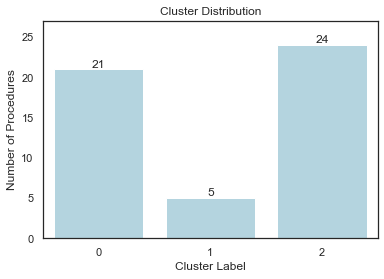

In [43]:
sns.set_theme(style='white')
plt.figure(figsize = (6,4))
ax = sns.barplot(x = 'cluster', y = 0, data = cluster_df.groupby(by = 'cluster').size().reset_index(),\
            color = 'lightblue')
ax.set_ylim(0,27)
ax.bar_label(ax.containers[0])
ax.set_title('Cluster Distribution')
ax.set_ylabel('Number of Procedures')
ax.set_xlabel('Cluster Label')
plt.savefig(path+'/figures/kmeans_optimal_clusters_barplot.png', bbox_inches = 'tight')
plt.show()

In [63]:
cluster_df[cluster_df.cluster == 0][['group']].to_csv(path+'/group0.csv', index=False)

In [51]:
cluster_df.groupby(by = ['cluster','phy_spec']).size().reset_index()

,cluster,phy_spec,0
0,0,GENERAL SURGERY (GS),5
1,0,OBSTETRICS/GYNECOLOGY (OBG),1
2,0,ORTHOPEDIC SURGERY (ORS),7
3,0,OTOLARYNGOLOGY (OTO),4
4,0,PLASTIC SURGERY (PS),1
5,0,PODIATRY (POD),1
6,0,UROLOGY (U),2
7,1,GENERAL SURGERY (GS),1
8,1,INTERNAL MEDICINE (IM),1
9,1,NEUROLOGICAL SURGERY (NS),2


<IPython.core.display.Javascript object>


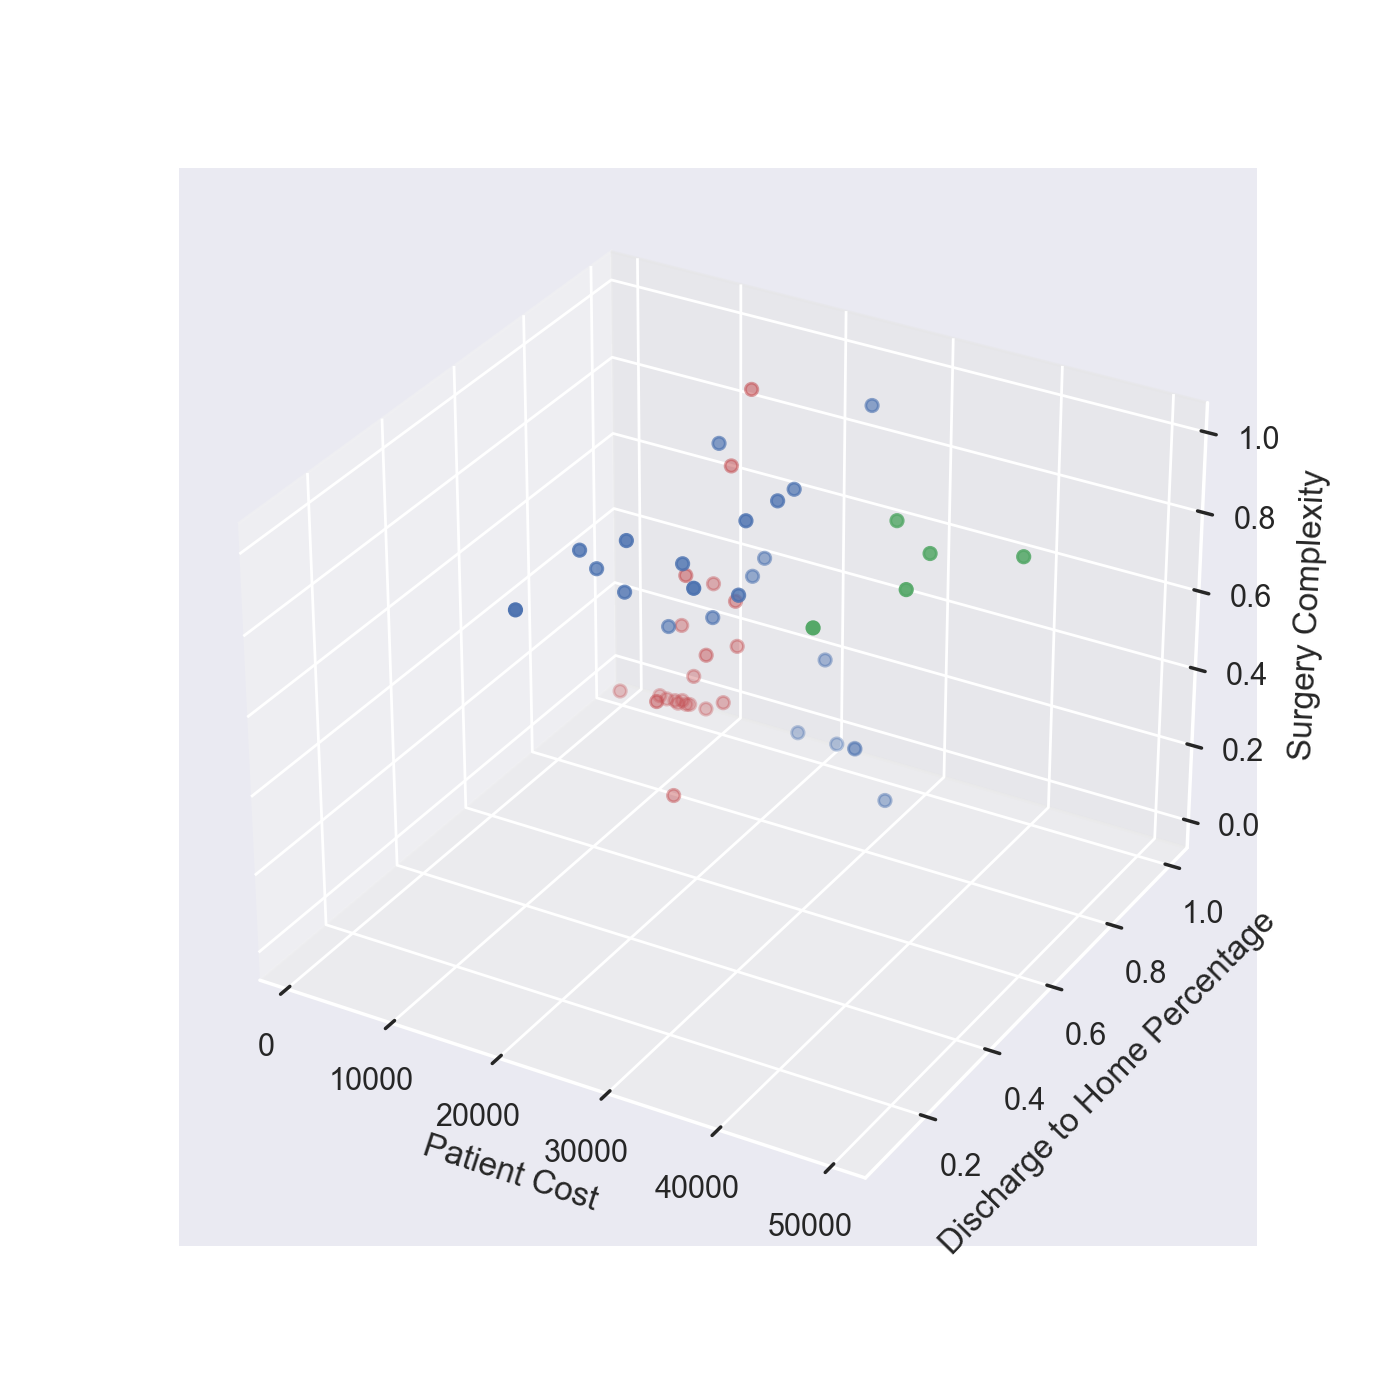

In [52]:
sns.set(style = "darkgrid")

%matplotlib notebook
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection = '3d')

x = cluster_df['pat_cost']
y = cluster_df['discharge_to_home_pct']
z = cluster_df['IP_pct']

col=cluster_df['cluster'].map({0:'r',1:'g',2:'b'})

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z, color = col)

plt.show()

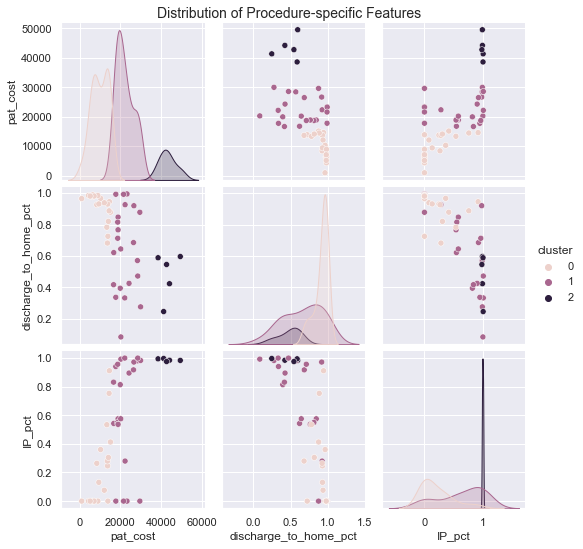

In [34]:
%matplotlib inline
f = sns.pairplot(cluster_df, hue = 'cluster')
f.fig.suptitle('Distribution of Procedure-specific Features', y = 1.01, fontsize = 14)
plt.savefig(path+'/figures/pairplotFeatures_kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()